In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
import os 
import pandas as pd

file_path = '../HW2/HW2_MNIST_train/'

# 讀取所有 txt 檔案，建立 DataFrame
data_list = []
for txt_file in os.listdir(file_path):
    if txt_file.endswith(".txt"):
        img_name = txt_file.replace(".txt", ".png")  
        img_path = os.path.join(file_path, img_name)
        txt_path = os.path.join(file_path, txt_file)
        
        with open(txt_path, "r") as f:
            label = f.read().strip().split('\t')  # 讀取標籤
            label.insert(0, img_path)
            data_list.append(label)
        

# 轉成 DataFrame
df = pd.DataFrame(data_list, columns=["img_path", "label", "upper_left_x", "upper_left_y", "h", "w"])

In [3]:
print(df.head())

                             img_path label upper_left_x upper_left_y  \
0  ../HW2/HW2_MNIST_train/0000000.png     0    0.3671875    0.3203125   
1  ../HW2/HW2_MNIST_train/0000001.png     0    0.5390625      0.53125   
2  ../HW2/HW2_MNIST_train/0000002.png     0    0.7734375    0.4296875   
3  ../HW2/HW2_MNIST_train/0000003.png     0     0.515625    0.2421875   
4  ../HW2/HW2_MNIST_train/0000005.png     0    0.2890625          0.5   

         h        w  
0  0.21875  0.21875  
1   0.4375   0.4375  
2  0.21875  0.21875  
3   0.4375   0.4375  
4   0.4375   0.4375  


In [23]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 定義 PyTorch Dataset
class ImageDataset(Dataset):
    # fetch information form the dataframe and transform the image
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = int(self.dataframe.iloc[idx, 1])

        # read image used in PIL
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

# 定義transform
transform = transforms.Compose([
    transforms.ToTensor(),           # a kind of normalization and transform to tensor
    transforms.Normalize((0.5,), (0.5,)),  # normalize the image
])

In [5]:
print(df['label'].value_counts())

label
1    10835
0    10785
7    10007
3     9812
2     9531
9     9524
6     9474
8     9427
4     9314
5     8687
Name: count, dtype: int64


In [24]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets with stratification to ensure even label distribution
train_df, val_df = train_test_split(df, test_size=0.3, random_state=3, stratify=df['label'])

# Define the batch size
batch_size = 32

# create dataset and dataloader
train_dset = ImageDataset(dataframe=train_df, transform=transform)
train_dataloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dset = ImageDataset(dataframe=val_df, transform=transform)
val_dataloader = DataLoader(val_dset, batch_size=batch_size, shuffle=False)

# 測試資料加載
for images, labels in train_dataloader:
    print(images.shape)  # 輸出: (batch_size, channels, height, width)
    print(images.squeeze(1).shape)  # 輸出: (batch_size, height, width)
    print(labels.shape)  # 輸出: (batch_size,)
    break

torch.Size([32, 1, 128, 128])
torch.Size([32, 128, 128])
torch.Size([32])


In [15]:
# Create CNN feature selector
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(1, 128, 128)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1), # (8,124,124)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,62,62)
            nn.Conv2d(8, 8, kernel_size=3, stride=1), # (8,60,60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (8,30,30)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=5, stride=1), # (32,26,26)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), # (32,24,24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # (32,12,12)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # (64,10,10)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # (64,8,8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64,4,4)
        )
        
    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [14]:
import torch.optim as optim
class simpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
            input_size: 每個時間步的輸入特徵數量
            hidden_size: LSTM 隱藏層維度大小
            num_layers: LSTM 堆疊層數, 代表用幾層 LSTM
            num_classes: 最後輸出類別數量
        """
        super(simpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.CNN_feature_extractor = CNN_Model()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(device)  # Initialize hidden state
        c0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(device)  # Initialize cell state

        # Extract CNN features
        cnn_features = self.CNN_feature_extractor(x)  # (batch_size, 64, 4, 4)
        batch_size = cnn_features.size(0)
        # Reshape: (batch_size, 64, 4, 4) -> (batch_size, 64, 16)
        cnn_features = cnn_features.view(batch_size, 64, 16)
        
        # Pass through LSTM
        out, (h_n, h_c) = self.lstm(cnn_features, (h0, c0))  # LSTM output

        # Fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# 設定超參數
input_size = 16   # 每個時間步的輸入特徵數量
hidden_size = 64  # LSTM 隱藏層大小
num_layers = 2     # LSTM 堆疊層數
num_classes = 10   # 分類數量，請根據你的問題調整
#time_step = 128    # 序列長度 (時間步)

Predict on Test data

Number of weighted  
$$ =  4 * hidden_size * (input\ dim + hidden\ size + 2) * 2^{bidirectional} 
\\ + 4 * hidden_size * (layer1\ output\ dim + hidden\ size + 2) * 2^{bidirectional} $$  
$$ = 4 * 64 * (16 + 64 + 2) * 2^1 + 4 * 64 * (128 + 64 + 2) * 2^1 $$
layer2 當中的　128 來自於 hidden state neuron = 64，且為bidirectional，所以128。   
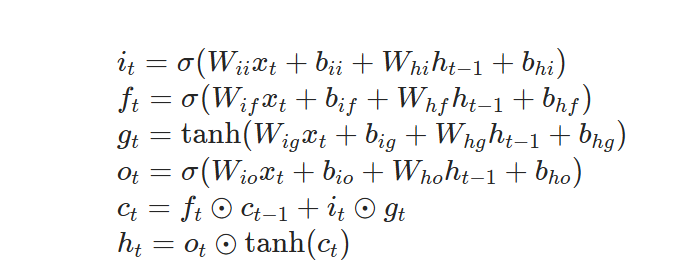

In [156]:
import torchinfo
model = simpleLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
simpleLSTM                               --
├─CNN_Model: 1-1                         --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  208
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  584
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-7                  6,432
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  9,248
│    │    └─ReLU: 3-10                   --
│    │    └─MaxPool2d: 3-11              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-12                 18,496
│    │    └─ReLU: 3-13                   --
│    │    └─Conv2d: 3-14                 36,928
│    │    └─ReLU: 3-15                   --
│    │    └─MaxPool2d: 3-16         

In [155]:
from matplotlib import pyplot as plt
Epoch = 10
learning_rate = 1e-4

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
valid_loss_values = []
train_accuracy_values = []
valid_accuracy_values = []
best_val_acc = 0

for epoch in range(1, Epoch+1):
    model.train()
    accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        # move data to device
        X_train = images.to(device)
        Y_train = labels.to(device).long()
        
        # X_train = X_train.squeeze(1)
        # zero gradients
        optimizer.zero_grad()
        # forward pass
        Y_pred = model(X_train)
        # compute loss
        l = loss(Y_pred, Y_train)
        # backward pass
        l.backward()
        # update weights
        optimizer.step()
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        accuracy += (predictions == Y_train).sum().item()
        # update the training "total" loss
        train_loss += (l.item() * Y_train.size(0))  # accumulate loss
        # print the loss and accuracy for every batch
        # print every batch_size batches
        print(f"In Epoch {epoch}: Batch {(i+1)*batch_size}/{len(train_dataloader.dataset)}: Loss: {l.item():.4f}, Accuracy: {(predictions == Y_train).sum().item()/Y_train.size(0):.4f}")
        
    # average the loss and accuracy
    accuracy /= len(train_dataloader.dataset)
    train_loss /= len(train_dataloader.dataset)
    print(f"Epoch {epoch}: Accuracy: {accuracy:.4f}, Train Loss: {train_loss:.4f}")

    # store the loss and accuracy
    loss_values.append(train_loss)
    train_accuracy_values.append(accuracy)

    # evaluate the model
    model.eval()
    valid_acc = 0.0
    valid_loss = 0.0
    # iterate through the validation set
    for images, labels in val_dataloader:
        # move data to device
        X_test = images.to(device).float()
        Y_test = labels.to(device).long()
        # X_test = X_test.squeeze(1)
        Y_pred = model(X_test)
        # compute loss
        l = loss(Y_pred, Y_test)
        # calculate accuracy
        predictions = Y_pred.argmax(dim=1)  # Get the predicted class index
        valid_acc += (predictions == Y_test).sum().item()
        # update the validation "total" loss
        valid_loss += l.item() * X_test.size(0)  # accumulate loss
        
    # store the loss and accuracy
    valid_acc /= len(val_dataloader.dataset)
    valid_loss /= len(val_dataloader.dataset)
    valid_loss_values.append(valid_loss)
    valid_accuracy_values.append(valid_acc)
    
    if best_val_acc < valid_acc:
        # update the best validation accuracy
        best_val_acc = valid_acc
        # save the model if the validation loss is the best so far
        torch.save(model.state_dict(), 'LSTM.pth')

    # print the loss and accuracy for every 5 epochs
    print(f"Epoch {epoch}: Validation Accuracy: {valid_acc:.4f}, Validation Loss: {valid_loss:.4f}")

In Epoch 1: Batch 32/68177: Loss: 0.6234, Accuracy: 0.8125
In Epoch 1: Batch 64/68177: Loss: 0.8364, Accuracy: 0.7188
In Epoch 1: Batch 96/68177: Loss: 0.6578, Accuracy: 0.7500
In Epoch 1: Batch 128/68177: Loss: 0.6776, Accuracy: 0.8125
In Epoch 1: Batch 160/68177: Loss: 0.3469, Accuracy: 0.9375
In Epoch 1: Batch 192/68177: Loss: 0.5444, Accuracy: 0.7812
In Epoch 1: Batch 224/68177: Loss: 0.4809, Accuracy: 0.8438
In Epoch 1: Batch 256/68177: Loss: 0.2795, Accuracy: 0.9062
In Epoch 1: Batch 288/68177: Loss: 0.7662, Accuracy: 0.6562
In Epoch 1: Batch 320/68177: Loss: 0.2885, Accuracy: 0.9062
In Epoch 1: Batch 352/68177: Loss: 0.1767, Accuracy: 0.9375
In Epoch 1: Batch 384/68177: Loss: 0.5234, Accuracy: 0.7500
In Epoch 1: Batch 416/68177: Loss: 0.5346, Accuracy: 0.7500
In Epoch 1: Batch 448/68177: Loss: 0.6411, Accuracy: 0.8125
In Epoch 1: Batch 480/68177: Loss: 0.4004, Accuracy: 0.8438
In Epoch 1: Batch 512/68177: Loss: 0.2491, Accuracy: 0.9688
In Epoch 1: Batch 544/68177: Loss: 0.3799, 

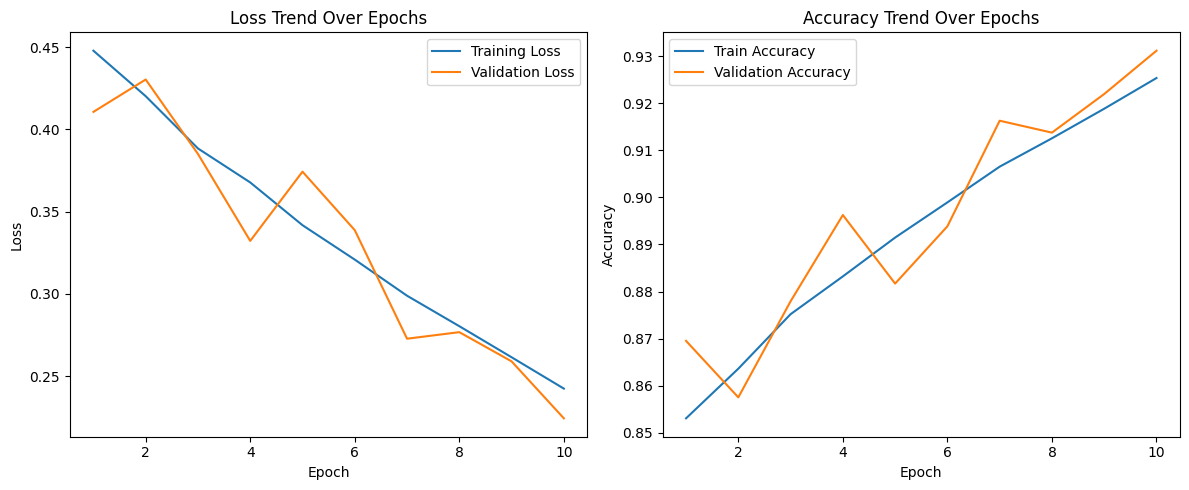

In [157]:
# plot the loss and accuracy trends
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot the loss trend
ax[0].plot(range(1, Epoch+1), loss_values, label='Training Loss')
ax[0].plot(range(1, Epoch+1), valid_loss_values, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Trend Over Epochs')
ax[0].legend()

# plot the accuracy trend
ax[1].plot(range(1, Epoch+1), train_accuracy_values, label='Train Accuracy')
ax[1].plot(range(1, Epoch+1), valid_accuracy_values, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Trend Over Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

Calculate Recall, Precision, F1-score on Validation data

Precision: 0.9315
Recall: 0.9304
F1 Score: 0.9307

Classification Report:
              precision    recall  f1-score   support

           0     0.9042    0.9567    0.9297      3236
           1     0.9790    0.9745    0.9767      3251
           2     0.9020    0.9210    0.9114      2859
           3     0.9706    0.9307    0.9502      2944
           4     0.9728    0.9334    0.9527      2794
           5     0.9117    0.9394    0.9253      2606
           6     0.9576    0.9536    0.9556      2842
           7     0.9499    0.9231    0.9363      3002
           8     0.8583    0.8911    0.8744      2828
           9     0.9086    0.8803    0.8942      2857

    accuracy                         0.9312     29219
   macro avg     0.9315    0.9304    0.9307     29219
weighted avg     0.9321    0.9312    0.9314     29219



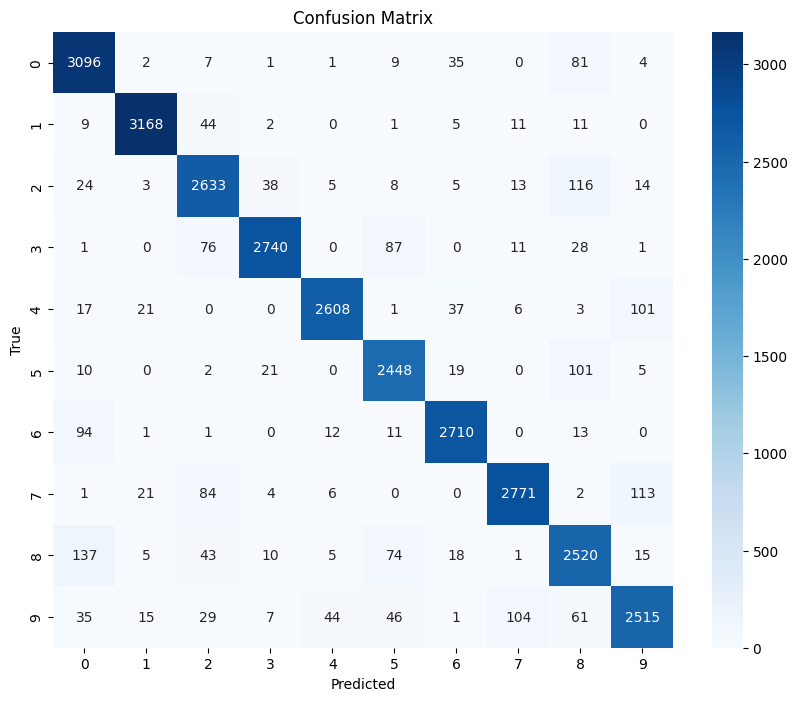

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# We need validation dataset with true labels to calculate metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Plot confusion matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Read test dataset

In [7]:
import os
import pandas as pd
file_path = '../HW2/HW2_MNIST_test/'

# test data only contains png files
img = []
for png_file in os.listdir(file_path):
    img.append(png_file)

# 轉成 DataFrame
df_test = pd.DataFrame(img, columns=["img_path"])

In [8]:
print(f'length = {len(df_test)}')
df_test.head()

length = 24350


,img_path
0,0000004.png
1,0000010.png
2,0000018.png
3,0000021.png
4,0000027.png


Predict on Test data

In [17]:
# 加載模型
model = simpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('LSTM.pth'))

<All keys matched successfully>

In [18]:
from PIL import Image
# 定義transform
transform = transforms.Compose([
    transforms.ToTensor(),           # a kind of normalization and transform to tensor
    transforms.Normalize((0.5,), (0.5,)),  # normalize the image
])

# store the results
result = []

for idx in range(len(df_test)):
    img_path = df_test.iloc[idx, 0]
    print(f"current processing image {idx}, name = {img_path}")
    img_path = os.path.join(file_path, img_path)
    
    image = Image.open(img_path).convert('L')  # read image used in PIL
    image = transform(image).unsqueeze(0).to(device)  # add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1).item()  # Get the predicted class index
        result.append(prediction)
    
# 將結果轉換為 DataFrame
result_df = pd.DataFrame({'image': df_test['img_path'], 'class': result})

current processing image 0, name = 0000004.png
current processing image 1, name = 0000010.png
current processing image 2, name = 0000018.png
current processing image 3, name = 0000021.png
current processing image 4, name = 0000027.png
current processing image 5, name = 0000038.png
current processing image 6, name = 0000040.png
current processing image 7, name = 0000041.png
current processing image 8, name = 0000042.png
current processing image 9, name = 0000055.png
current processing image 10, name = 0000057.png
current processing image 11, name = 0000058.png
current processing image 12, name = 0000059.png
current processing image 13, name = 0000062.png
current processing image 14, name = 0000064.png
current processing image 15, name = 0000065.png
current processing image 16, name = 0000066.png
current processing image 17, name = 0000069.png
current processing image 18, name = 0000071.png
current processing image 19, name = 0000072.png
current processing image 20, name = 0000080.png
cu

In [19]:
print(result_df.head(10))

         image  class
0  0000004.png      0
1  0000010.png      0
2  0000018.png      0
3  0000021.png      0
4  0000027.png      0
5  0000038.png      0
6  0000040.png      0
7  0000041.png      0
8  0000042.png      0
9  0000055.png      0


In [20]:
# 存成 CSV 檔案
output_csv = "HW3_prob1_LSTM.csv"
result_df.to_csv(output_csv, index=False)

print(f"預測結果已儲存至 {output_csv}")

預測結果已儲存至 HW3_prob1_LSTM.csv
